# Bayesian survival analysis with LFP

We fit a Stan model for survival analysis (event time = stop time) using trial type and LFP power as covariates. This notebook examines the results.

In [1]:
import numpy as np
import pandas as pd
import pystan
import pickle
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
dtup = 30, 1

In [3]:
fname = '.'.join([str(x) for x in dtup]) 

In [4]:
dat = pd.read_csv('data/' + fname + '.lfpsurvdata.csv', index_col=0)
dat.shape

(1093, 164)

### Take an average across trials

In [5]:
dat['rel_time'] = np.around(dat['rel_time'], decimals=3)
aa = dat.set_index('rel_time').iloc[:, 2:]
aa.head()

,trial,delta.17,delta.18,delta.19,delta.20,delta.21,delta.22,delta.23,delta.24,delta.25,...,gamma.39,gamma.40,gamma.41,gamma.42,gamma.43,gamma.44,gamma.45,gamma.46,gamma.47,gamma.48
rel_time,,,,,,,,,,,,,,,,,,,,,
0.1,12,-1.421659,-0.818839,-1.339933,0.239694,0.779082,-0.646151,-0.141094,-0.989535,-1.160590,...,-1.038540,-0.298549,-0.154720,-0.797831,-0.153967,-0.936449,-0.928940,-0.894454,0.316216,-0.266183
0.2,12,-1.270871,-0.642550,-1.180364,0.215556,0.566904,-0.596621,-0.080006,-0.933032,-1.066399,...,-0.913071,-0.269608,-0.196484,-0.735425,-0.124397,-0.837826,-0.739241,-0.840463,0.327299,-0.317152
0.3,12,-1.244372,-0.594775,-1.175332,0.110471,0.279770,-0.619534,-0.163026,-0.957253,-0.991218,...,-1.034978,-0.376542,-0.433081,-0.729608,-0.240668,-0.861878,-0.789202,-0.764282,0.150566,-0.374116
0.4,12,-1.327887,-0.684628,-1.280759,-0.171519,-0.066585,-0.752944,-0.587741,-1.121385,-0.961702,...,-1.229124,-0.432265,-1.025223,-0.933506,-0.510899,-0.996125,-1.021412,-0.994722,-0.052372,-0.819329
0.5,12,-1.405731,-0.717963,-1.399249,-0.309370,-0.311460,-0.830263,-0.918437,-1.263854,-0.941211,...,-1.146699,-0.631152,-1.335714,-1.170659,-0.345688,-1.132992,-1.027406,-1.219837,-0.075535,-1.293797


<IPython.core.display.Javascript object>


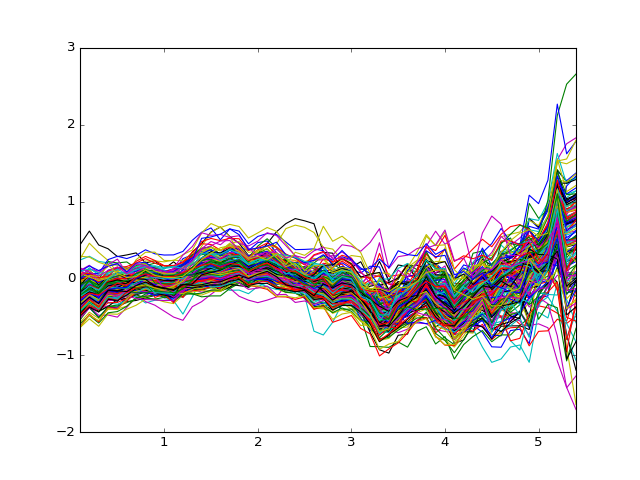

In [6]:
bb = dat.drop(['event', 'ttype', 'trial'], axis=1).set_index('rel_time')
mn = bb.groupby(by=lambda x: np.around(x, decimals=1)).mean()
ss = bb.groupby(by=lambda x: np.around(x, decimals=1)).std()
(mn).plot(legend=False)
# plt.ylim(-1, 1);

<IPython.core.display.Javascript object>


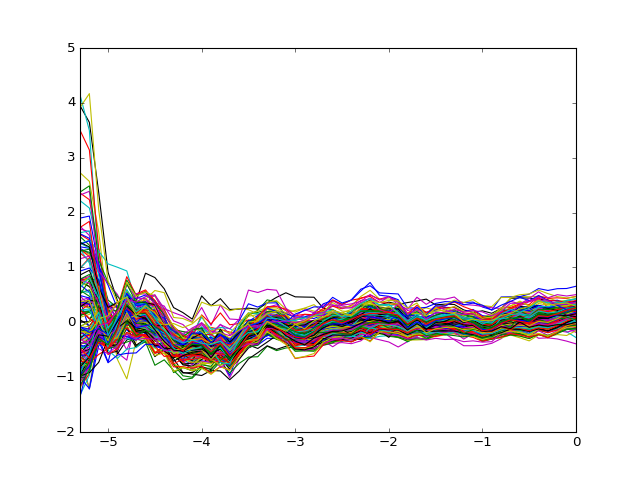

In [7]:
def negtime(df):
    df.index = df.index - df.index.max()
    return df

# get time relative to stop
bb = dat.set_index('rel_time').groupby('trial').apply(negtime)
bb.index = bb.index.droplevel(0)

# take mean across trials
bb = bb.drop(['event', 'ttype', 'trial'], axis=1)
mn = bb.groupby(by=lambda x: np.around(x, decimals=1)).mean()
ss = bb.groupby(by=lambda x: np.around(x, decimals=1)).std()
(mn).plot(legend=False)
# plt.ylim(-1, 1);

In [8]:
with open('data/' + fname + '.stan_model', 'rb') as f:
    sm = pickle.load(f)
with open('data/' + fname + '.stan_samples', 'rb') as f:
    fit = pickle.load(f)

In [9]:
def get_summ_df(fit, var):
    summ = fit.summary(var)
    return pd.DataFrame(summ['summary'], index=summ['summary_rownames'], columns=summ['summary_colnames'])

In [10]:
betas = get_summ_df(fit, 'beta')

In [11]:
betas

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],0.010764,0.002729,0.073421,-0.047301,-0.001861,1.386941e-04,0.005036,0.182838,724.0,1.004578
beta[1],0.004834,0.001828,0.051327,-0.053555,-0.002907,6.599106e-05,0.004384,0.102249,788.0,1.002052
beta[2],0.018376,0.004604,0.116394,-0.042244,-0.001665,2.116273e-04,0.005566,0.218791,639.0,1.002180
beta[3],0.001923,0.001882,0.049339,-0.058082,-0.003556,1.105053e-05,0.003038,0.061101,687.0,1.002688
beta[4],0.001590,0.001656,0.043666,-0.082830,-0.002614,1.368473e-05,0.003554,0.100573,695.0,1.002119
beta[5],0.002578,0.003026,0.072999,-0.089674,-0.003505,-1.639250e-05,0.002794,0.125497,582.0,0.998453
beta[6],-0.004828,0.001622,0.045884,-0.094712,-0.004218,-6.211830e-05,0.002776,0.043902,800.0,0.999748
beta[7],-0.003112,0.001886,0.051605,-0.112751,-0.003900,-1.520192e-05,0.003374,0.087509,749.0,1.003700
beta[8],0.006293,0.001902,0.053809,-0.061426,-0.001700,5.701840e-05,0.003972,0.101785,800.0,1.001223
beta[9],-0.002512,0.001574,0.044533,-0.105010,-0.002879,1.249739e-05,0.002554,0.060577,800.0,0.996902


In [12]:
def plot_coeffs(df, sorted=False, transform=None):
    fig = plt.figure()
    if transform:
        b_m = transform(df['mean'])
        b_lo = b_m - transform(df['2.5%'])
        b_hi = transform(df['97.5%']) - b_m
    else:
        b_m = df['mean']
        b_lo = b_m - df['2.5%']
        b_hi = df['97.5%'] - b_m

    if len(b_m) > 1:
        if sorted:
            idx = np.argsort(b_m)
        else:
            idx = np.arange(len(b_m))

        b_m, b_lo, b_hi = b_m[idx], b_lo[idx], b_hi[idx]

        contains_1 = (df['2.5%'][idx] < 0) & (df['97.5%'][idx] > 0)
        
    else:
        contains_1 = (df['2.5%'] < 0) & (df['97.5%'] > 0)
    
    plt.errorbar(np.arange(len(b_m)), b_m, yerr=[b_lo, b_hi], capthick=0, 
                 marker='o', linestyle='None')

    # plot "significant" coefficients in red
    
    sigs = np.where(~contains_1)[0]
    plt.errorbar(sigs, b_m[sigs], yerr=[b_lo[sigs], b_hi[sigs]], capthick=0, 
                 marker='o', linestyle='None', color='red')

    plt.axhline(1., color='k', zorder=-1)
    plt.xlim(-1, len(b_m) + 1)
    
    return fig

<IPython.core.display.Javascript object>


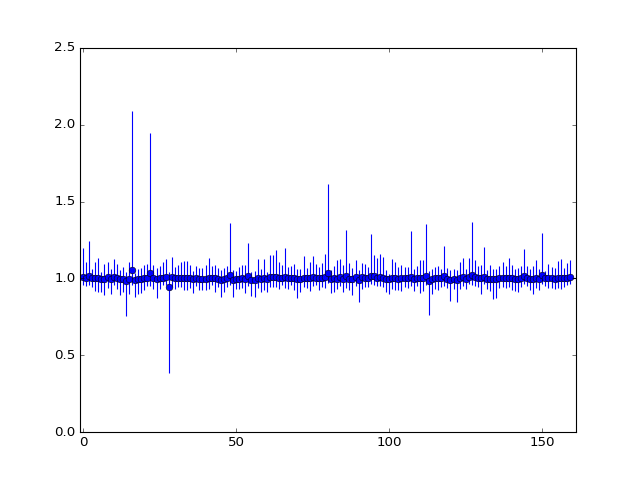

In [13]:
plot_coeffs(betas, sorted=False, transform=np.exp);

In [14]:
haz_means = get_summ_df(fit, 'mm')
haz_means.head()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mm[0],4.443038,0.047961,1.154064,2.527894,3.617364,4.301306,5.144378,6.956461,579.0,1.006134
mm[1],4.577705,0.065700,1.578163,1.943923,3.568835,4.457665,5.417629,7.820871,577.0,0.999989
mm[2],3.315901,0.038844,0.929823,1.885959,2.709935,3.220683,3.785728,5.333929,573.0,1.004397


<IPython.core.display.Javascript object>


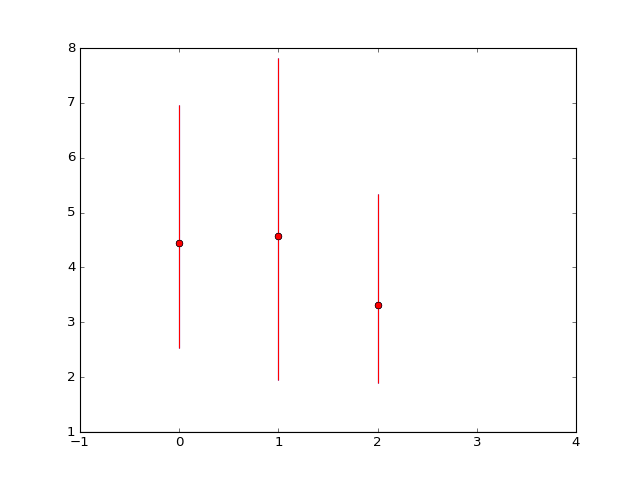

In [15]:
plot_coeffs(haz_means);